In [12]:
from src.database import DatabaseXRD,snip,Phase,MixPhase
from src.gaussnewton import GaussNewton
from numpy import newaxis,loadtxt,save,diag,histogram,arange,linspace,sin,concatenate,array,exp,pi,zeros,ones,prod,newaxis,arctan,savetxt,c_,fabs,sqrt,concatenate
from numpy.random import normal
from numpy.linalg import pinv,inv
from scipy.optimize import curve_fit,least_squares
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

from matplotlib.pyplot import imshow,plot,show,vlines,xlim,ylim,figure,semilogx,scatter,xlabel,ylabel,subplots,gca,savefig

from glob import glob

from scipy import signal
from numpy import fft,pad,concatenate,stack

from src.spectra import Spectra
from src.xrd_data import DataXRD

In [2]:
database = DatabaseXRD().read_cifs('Database/')

calcite = database['Calcite'][0]
hydrocerussite = database['Hydrocerussite'][0]
cinnabar = database['Cinnabar'][2]
spinel = database['Spinel'][0]
barite = database['Barite'][0]
lazurite = database['Lazurite'][0]

In [3]:
xrd_data = DataXRD().load_h5('/home/zdenek/Projects/pyMaXRDXRF/Oslo/Calibration1/M491/ProfiloXRD/data.h5')

Loading: /home/zdenek/Projects/pyMaXRDXRF/Oslo/Calibration1/M491/ProfiloXRD/data.h5
Load inverted
Load convoluted


In [4]:
def fce_calibration(x,a,beta,s):
    return (arctan((x+a)/s)) * 180 / pi + beta

In [6]:
files = glob('Profilo/Lazurite/roi*.dat')
phase = MixPhase([lazurite])

xrd_gauss_newton = []
xrd_spectra = []

for file in files:
    
    spectra = Spectra(file)
    spectra.calibrate_from_file('/home/zdenek/Projects/pyMaXRDXRF/Oslo/Calibration1/M0795/CappelloGialloXRD/calibration.ini')
    spectra.convolve(4).raw_snip(m=32)
    
    xrd_gauss_newton += [GaussNewton(phase,spectra)]

(0.0, 1280.0)

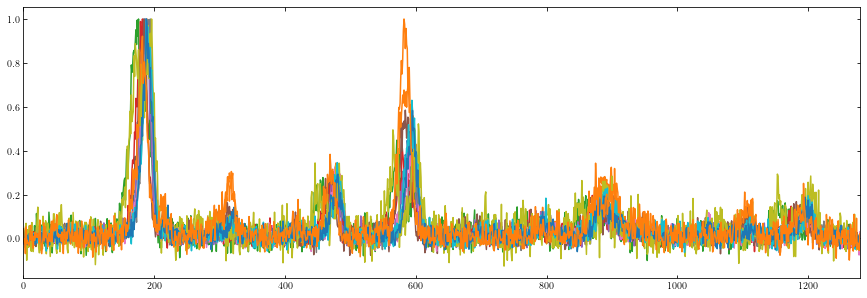

In [7]:
figure(figsize=(15,5))
for g in xrd_gauss_newton:
    plot(g.spectra.intensity)
xlim(0,1280)

[-1186.2597891600492, 51.000000000000036, 1955.0499869485873] 1.355083030592844
[-1180.1472683193003, 50.99999999999966, 1941.0376171806533] 6.107877959462116
[-1197.8602115402116, 51.00000000000095, 2001.2330142324597] 7.469100546017617
[-1175.9333411860157, 51.000000000000085, 1946.9015493823515] 1.8311598319545497
[-1185.3389745753336, 50.99999999999994, 1955.8992025645346] 1.431304078603345
[-1175.0607689466585, 50.999999999998856, 1942.843377525215] 2.569641986551683
[-1190.743928690851, 51.0000000000005, 1960.6734100172146] 1.433410039536341
[-1194.238019881952, 51.000000000000384, 1963.7626098159265] 1.133213578803605
[-1203.5189366783436, 51.000000000001926, 1990.105023412514] 14.0760802453981
[-1191.140389683253, 51.00000000000055, 1959.721287819825] 2.2851890503957
[-1190.2691729410997, 51.000000000000526, 1959.2528256068636] 1.734048934990571
[-1173.3412903035185, 50.999999999998145, 1940.3397774855996] 5.4653466220668845


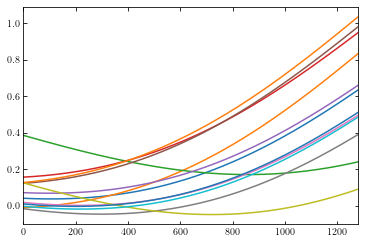

In [8]:
x = arange(1280)
    
for g in xrd_gauss_newton:
    
    g.spectra.opt = [-1186.106076632754, 51., 1954.6937605682037]
    
    for _ in range(4):
        g.calibration_nobeta(alpha=1)
        g.opt = g.spectra.opt.copy()
        
    for _ in range(4):
        g.calibration_nobeta(alpha=0.5)
        g.opt = g.spectra.opt.copy()

    print(g.spectra.opt,g.dz)
    
    opt = g.spectra.opt
    opt_file = g.spectra.opt_file
    
    y_new = fce_calibration(x,*opt)
    y_old = fce_calibration(x,*opt_file)
    
    plot(y_new-y_old)
    xlim(0,1280)

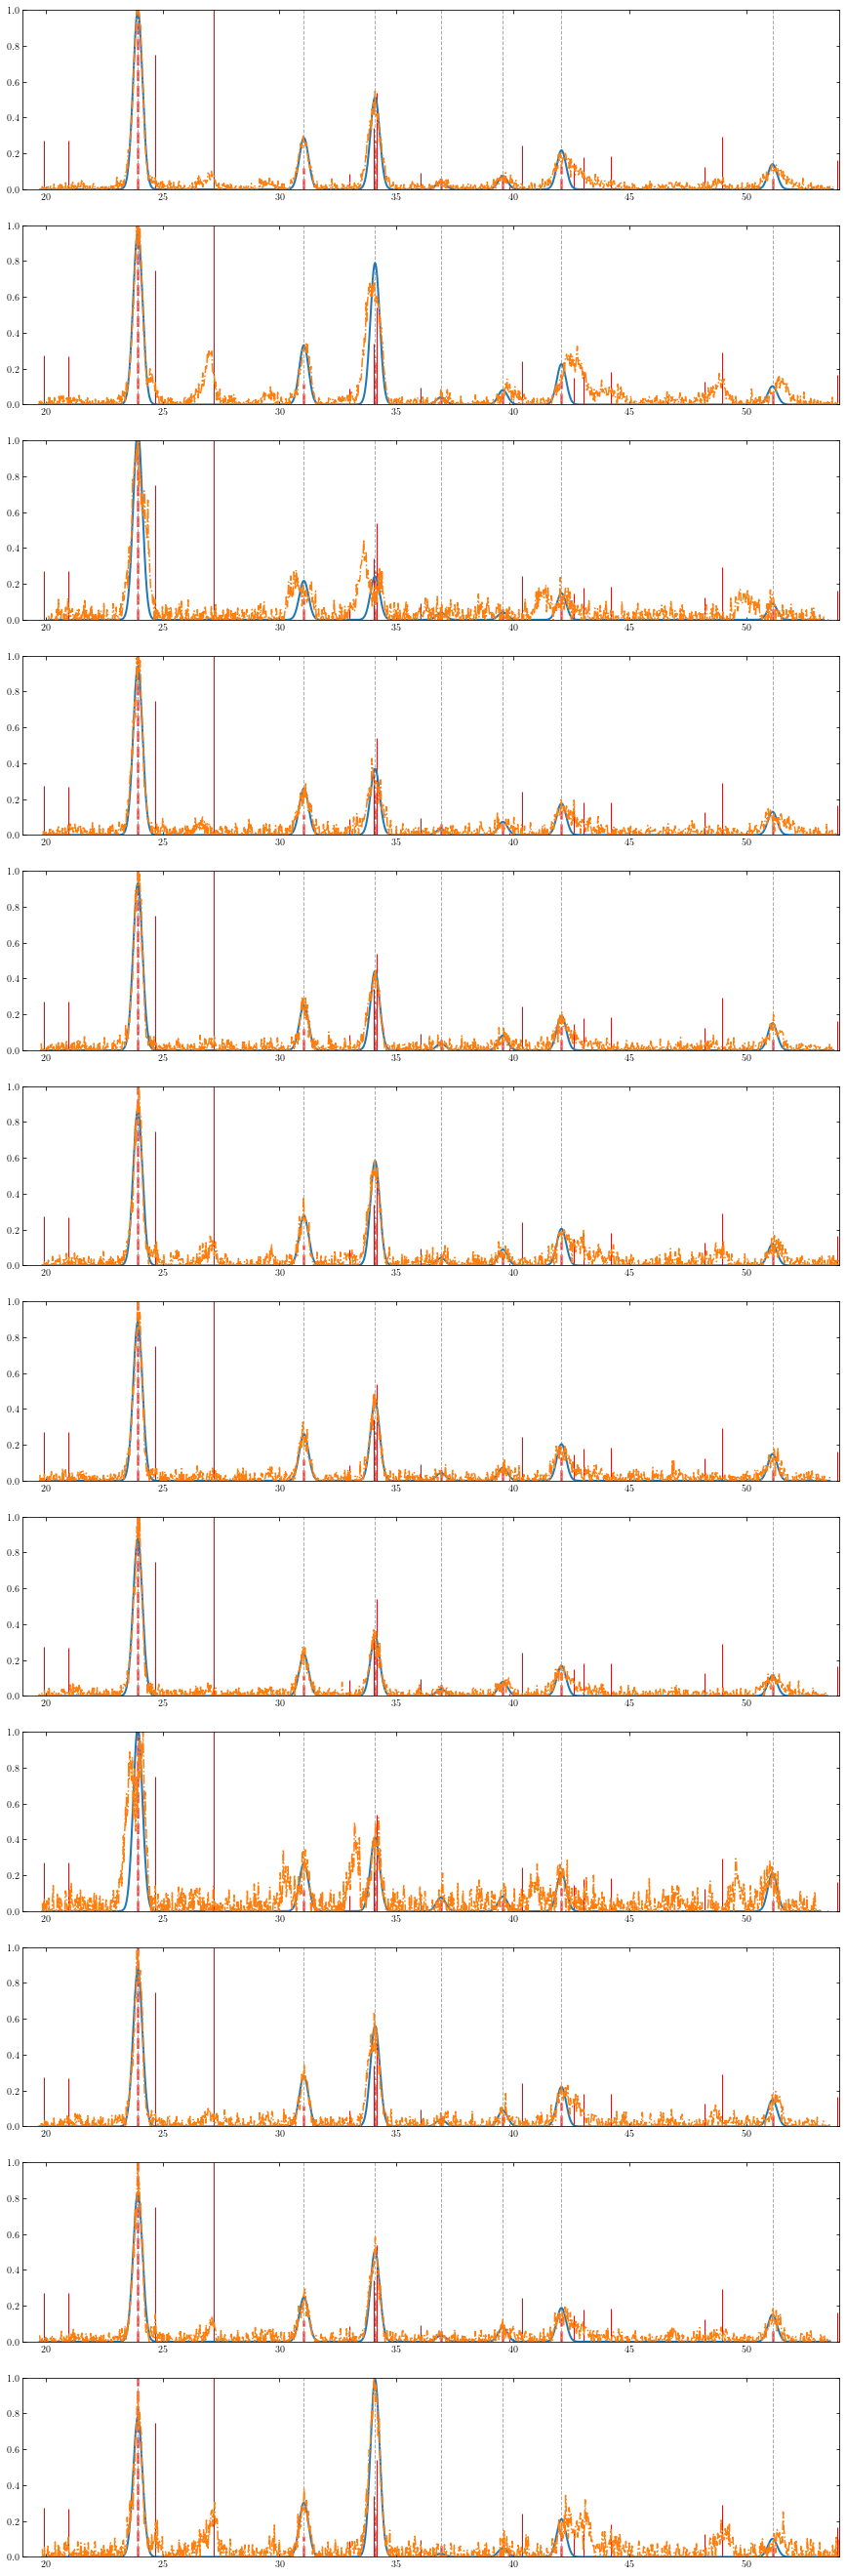

In [9]:
%matplotlib inline
fig,ax = subplots(len(xrd_gauss_newton),1,figsize = (15,48))

for i,g in enumerate(xrd_gauss_newton):
    
    g.spectra.opt = g.opt.copy()
    s = g.spectra
    
    t,r = hydrocerussite.get_theta()
    
    ax[i].vlines(g.mu,0,g.i,'r',alpha=0.5,ls='--',lw=3)
    ax[i].plot(g.theta,g.z,'-',lw=2)
    ax[i].plot(s.theta,s.intensity,'-.')
    ax[i].vlines(g.mu,0,1,'k',alpha=0.33,ls='--',lw=1)
    
    ax[i].vlines(t,0,r,'r',lw=1)
    
    ax[i].vlines(g.mu[g.gamma<0],0,1,'c',alpha=1,ls='--',lw=3)
    
    ax[i].set_xlim(19,54)
    ax[i].set_ylim(0,1)

In [10]:
%%time

data = xrd_data.inverted.reshape(-1,1280)
profilo_gauss_newton = []

for d in data[:]:
    spectra = Spectra()
    spectra.from_array(d)
    spectra.opt[:] = array([-1185.2366578999117, 50.99999999999997, 1955.6511408474753])
    spectra.convolve(4).raw_snip(m=32)
    
    g = GaussNewton(lazurite,spectra)
    
    for _ in range(4):
        g.calibration_nobeta(alpha=1)
        g.opt = g.spectra.opt.copy()
        
    for _ in range(2):
        g.calibration_nobeta(alpha=0.5)
        g.opt = g.spectra.opt.copy()

    #print(g.spectra.opt)
    
    profilo_gauss_newton += [g]
    

CPU times: user 3min 36s, sys: 244 ms, total: 3min 36s
Wall time: 3min 36s


In [35]:
%%time
for g in profilo_gauss_newton:
    for _ in range(4):
        g.calibration_nobeta(alpha=1)
        g.opt = g.spectra.opt.copy()

CPU times: user 1min 57s, sys: 5.55 ms, total: 1min 57s
Wall time: 1min 57s


In [17]:
out = array([g.dz for g in profilo_gauss_newton])
out = out.reshape(95,170)
save('Lazurite.npy',out)

a = array([g.opt[0] for g in profilo_gauss_newton])
a = a.reshape(95,170)
a.max(),a.argmin()
save('Lazurite_a.npy',a)

In [30]:
f = (a > -1150)
out[f] = 100

In [33]:
f = (xrd_data.inverted[:,:,185] < 50)
out[f] = 100

In [34]:
out.shape,xrd_data.inverted.shape

((95, 170), (95, 170, 1280))

In [13]:
out.max(),out.min()


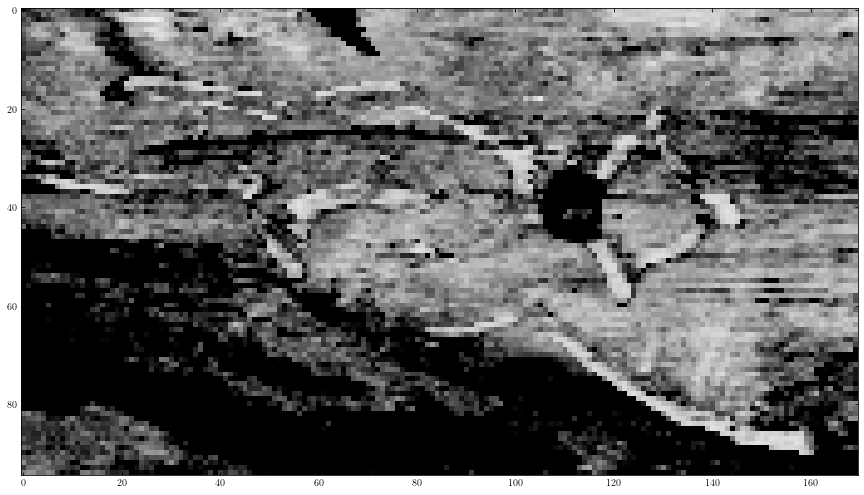

In [14]:
figure(figsize=(15,15))
imshow(out[::-1]*-1,vmin=-8,vmax=0,cmap='gray')
savefig('Lazurite_loss.png')

0.4757973665946068


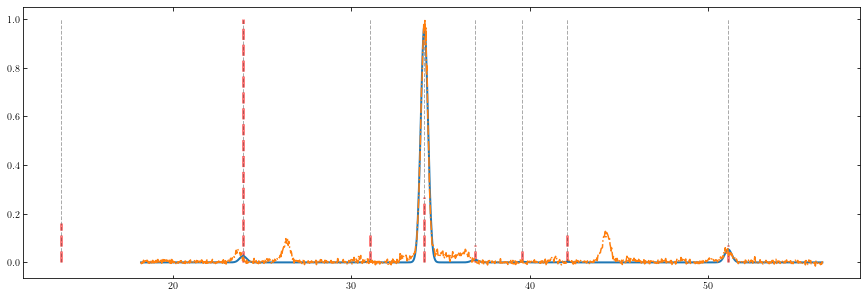

In [15]:
figure(figsize=(15,5))
g = profilo_gauss_newton[out.argmin()]
s =g.spectra

for _ in range(64):
    g.calibration_nobeta()
print(g.dz)
    
vlines(g.mu,0,g.i,'r',alpha=0.5,ls='--',lw=3)
plot(g.theta,g.z,'-',lw=2)
plot(s.theta,s.intensity,'-.')
vlines(g.mu,0,1,'k',alpha=0.33,ls='--',lw=1)

vlines(g.mu[g.gamma<0],0,1,'c',alpha=1,ls='--',lw=3)

(-975.1311239346682, 15346)

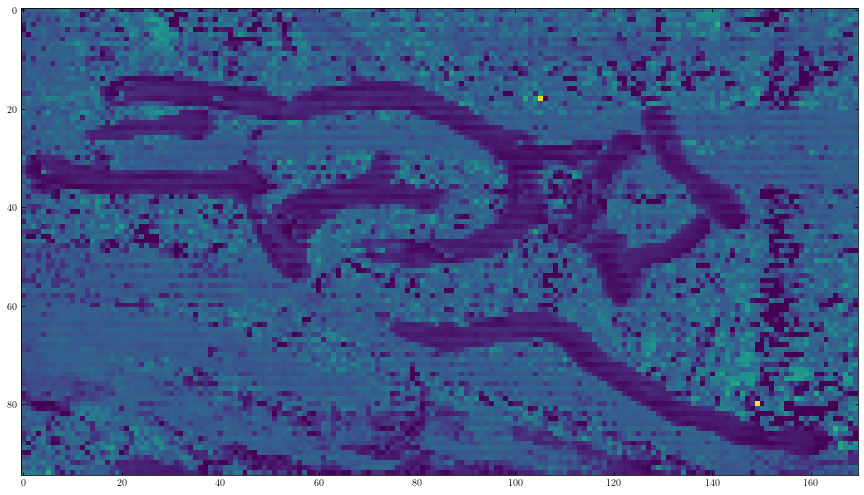

In [26]:
%matplotlib inline
figure(figsize=(15,15))
imshow(a[::-1],vmin=-1200)

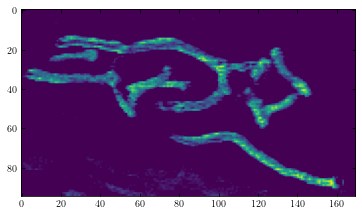

In [24]:
imshow(xrd_data.inverted[:,:,185][::-1],vmin=50)